# 결과
- 2024.01.23
손실함수는 CNN보다 높게나왔고 최종결과는 비슷한것같다. 
그런데 lstm이 cnn보다 다른데이터셋(최신) 입력시, 더 비슷하게 맞춘것같다.

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
        print("Num GPUs Available: ", len(gpus))


Name: /physical_device:GPU:0 Type: GPU
Num GPUs Available:  1


In [2]:
import yfinance
import numpy as np
import tensorflow as tf
import os

# Original datasetb
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< df >", df.head(21), "< dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    print("< y > \n",y[:2],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    # 
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)


X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

print(" < last y > \n",y[:10], y.shape)
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_674/2861494198.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_674/2861494198.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


'< df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


< X > 
 [[[0.0097097  0.01049631 0.00943526 0.01045606]
  [0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]]

 [[0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]
  [0.00923281 0.0097041  0.00928058 0.00947997]]] (5021, 10, 4)
< y > 
 [[0.00

In [4]:
from keras.models import load_model, model_from_json
def load_keras_model(optimizer, loss):
    dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/models'
    os.chdir(dirx)
    json_file = open("LSTM_network.json",'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights('LSTM_weights.h5')
    return model
LSTM = load_keras_model('adam','mse')

In [6]:
# 평가
print("[ 손실함수 ]")
LSTM.evaluate(X_test,y_test)

[ 손실함수 ]
 4/16 [======>.......................] - ETA: 0s - loss: 1.4655e-06

2024-01-23 12:47:46.217649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 22ms/step - loss: 1.0604e-06


1.0603841928968905e-06

 7/16 [============>.................] - ETA: 0s

2024-01-23 12:48:04.100966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 21ms/step


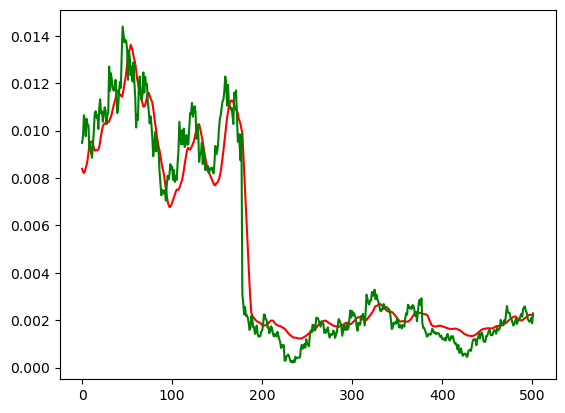

In [7]:
from matplotlib import pyplot as plt
pred_test = LSTM.predict(X_test)
plt.plot(pred_test,'r')  # 예측 종가값(정규화된 값)
plt.plot(y_test,'g')     # 실제 종가값(정규화된 값)

In [10]:
# 데이터 수집
df2 = yfinance.download('AAPL','2023-12-1','2024-1-18')
df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
display("< original dataset >", df2.tail(10))

# 정규화
dataset2, minmax2 = normalize_data(df2)
values2 = dataset2.values
display("< nomalized dataset >", dataset2.head(21),dataset2.shape)
# 종가 예측은 11번째부터 시작 (12.15일부터)

# 데이터 전처리
n_steps = 10   # 10일분량씩 쪼개어, 인풋데이터를 만듦
new_X,new_y,new_n_features = data_setup(n_steps, values2)
display("new_X", new_X[:3], new_X.shape)
display("new_y", new_y, new_y.shape)



[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_674/1421111473.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_674/1421111473.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)


'< original dataset >'

,Open,High,Low,Close
Date,,,,
2024-01-03,184.220001,185.880005,183.429993,184.250000
2024-01-04,182.149994,183.089996,180.880005,181.910004
2024-01-05,181.990005,182.759995,180.169998,181.179993
2024-01-08,182.089996,185.600006,181.500000,185.559998
2024-01-09,183.919998,185.149994,182.729996,185.139999
2024-01-10,184.350006,186.399994,183.919998,186.190002
2024-01-11,186.539993,187.050003,183.619995,185.589996
2024-01-12,186.059998,186.740005,185.190002,185.919998
2024-01-16,182.160004,184.259995,180.929993,183.630005


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2023-12-01,0.540895,0.521946,0.538324,0.594212
2023-12-04,0.520000,0.432385,0.432561,0.487300
2023-12-05,0.533731,0.690391,0.594771,0.722977
2023-12-06,0.786865,0.711744,0.709448,0.658004
2023-12-07,0.737911,0.725979,0.797385,0.773184
2023-12-08,0.771940,0.784698,0.802139,0.858240
2023-12-11,0.706865,0.636418,0.668449,0.708801
2023-12-12,0.705074,0.709372,0.686275,0.799174
2023-12-13,0.825074,0.903915,0.872252,0.991140


(31, 4)

< X > 
 [[[0.5408954  0.5219456  0.53832424 0.59421194]
  [0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]]

 [[0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]
  [0.9707459  0.9276393  1.         0.96810436]]] (21, 10, 4)
< y > 
 [[0.9707

'new_X'

array([[[0.5408954 , 0.5219456 , 0.53832424, 0.59421194],
        [0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.82507414, 0.90391487, 0.8722523 , 0.99114037],
        [1.        , 1.        , 0.95008934, 1.        ]],

       [[0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.8

(21, 10, 4)

'new_y'

array([0.96810436, 0.8688718 , 0.93089205, 0.80626124, 0.7974007 ,
       0.73360944, 0.7011226 , 0.7070287 , 0.73242784, 0.6704076 ,
       0.26343796, 0.18133526, 0.04311935, 0.        , 0.2587125 ,
       0.2339046 , 0.29592484, 0.26048443, 0.27997658, 0.14471418,
       0.08860008], dtype=float32)

(21,)

1/1 [==============================] - 0s 69ms/step
[ 손실함수 ]
1/1 [==============================] - 0s 68ms/step - loss: 0.0140


array([[0.89203614],
       [0.9069415 ],
       [0.8602326 ],
       [0.9194581 ],
       [0.8595144 ]], dtype=float32)

21

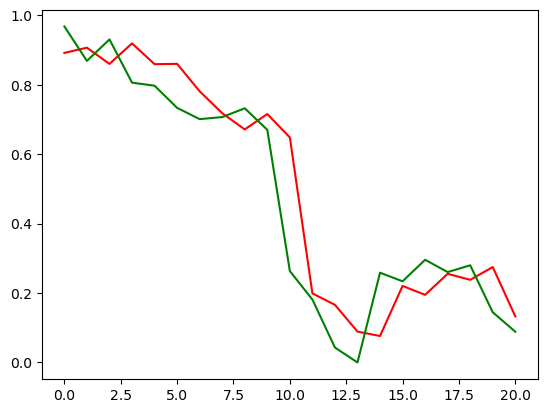

In [11]:
# 예측하기
pred_Apple = LSTM.predict(new_X)
# 평가
print("[ 손실함수 ]")
LSTM.evaluate(new_X,new_y)
display(pred_Apple[:5], len(pred_Apple))

# 정규화 예측값 시각화
plt.plot(pred_Apple,'r')  # 예측 종가값(정규화된 값)
plt.plot(new_y,'g')     # 실제 종가값(정규화된 값)